In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import networkx as nx
from scipy.optimize import minimize

from docplex.mp.model import Model
from collections import defaultdict
from openqaoa.problems.converters import FromDocplex2IsingModel # function to translate docplex problems into Ising Hamiltonians

import networkx as nx
import numpy as np
import time
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator

from qiskit_aer import AerSimulator

# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# service = QiskitRuntimeService(name="Purdue")

# backend = BasicSimulator()
backend = AerSimulator()
# backend_cloud = service.backend("ibmq_qasm_simulator")

colors = plt.get_cmap("jet", 20)

label_size = 14
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 
plt.rcParams['axes.labelsize'] = label_size 
plt.rcParams['legend.fontsize'] = label_size 

In [3]:
def QUBO(G):
    # WMaxCut model as a QUBO problem
    mdl = Model('MaxCut')
    num_vertices = G.number_of_nodes()
    x = {i: mdl.binary_var(name=f"x_{i}") for i in range(num_vertices)}
    mdl.minimize(-mdl.sum(G[i][j]["weight"]*(x[i] * (1 - x[j]) + x[j] * (1 - x[i]))  for i, j in G.edges))
    return mdl

def cost(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] + x[j] in ["01","10"]:
            obj += G[i][j]["weight"]
    return - obj

def energy(x, hamiltonian):
    obj = 0
    spin = {"1":-1, "0":1}
    for k, v in hamiltonian.items():
        if len(k) == 2:
            obj += v * spin[x[k[0]]] * spin[x[k[1]]]
        elif len(k) == 1:
            obj += v * spin[x[k[0]]]
        else:
            print(k, v)
    return obj


def qaoa_circ(hamiltonian, gammas, betas, n_qubits):
    p = len(gammas)
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    for ii in range(p):
        for qbits, value in hamiltonian.items():
            if len(qbits) == 1:
                qc.rz(2*gammas[ii]*float(value), qbits[0])
        for qbits, value in hamiltonian.items():
            if len(qbits) == 2:
                qc.rzz(2*gammas[ii]*float(value), *qbits)
        qc.rx(-2*betas[ii], range(n_qubits))
    qc = qc.reverse_bits()
    qc.measure_all()
    return qc

def mitigate(samples_dict, hamiltonian, random=False):
    change = {"0":"1", "1":"0"}
    new_samples = defaultdict(int)
    for bitstring, counts in samples_dict.items():
        nq = len(bitstring)
        best_string = bitstring
        best_cost = energy(bitstring, hamiltonian)
        list_qubits = np.arange(nq)
        if random:
            np.random.shuffle(list_qubits)
        for qi in list_qubits:
            new_string = "".join((change[i] if n == qi else i) for n, i in enumerate(best_string))
            new_cost = energy(new_string, hamiltonian)
            if new_cost < best_cost:
                best_string = new_string
                best_cost = new_cost
        new_samples[best_string] += counts
    return new_samples

In [3]:
np.random.seed(1)
problems = np.load("./Data/WMaxCut/problems.npy", allow_pickle=True).item()
# problems = {}
nodes_list_qubo = range(31, 41)
prob_G = 0.7
random_cases = 100
# Generate graphs with the above condition for different number of nodes
for nodes in nodes_list_qubo: 
    print(f"-------     qubits: {nodes}    ---------")
    problems[nodes] = {}
    for kk in range(random_cases):
        problems[nodes][kk] = {}
        G = nx.Graph()
        G.add_nodes_from(range(nodes))
        for i in range(nodes - 1):
            for j in range(i+1, nodes):
                if np.random.rand() < prob_G:
                    w = round(np.random.rand(),3)
                    G.add_weighted_edges_from([[i,j,w]])
        problems[nodes][kk]["G"] = G
        mdl = QUBO(G)
        ising_hamiltonian = FromDocplex2IsingModel(mdl).ising_model
        max_w = np.max(np.abs(ising_hamiltonian.weights))
        # max_w = np.max(np.abs([w for w, qbs in zip(ising_hamiltonian.weights, ising_hamiltonian.terms) if len(qbs)==2]))
        ising_hamiltonian.weights = [w/max_w for w in ising_hamiltonian.weights]
        ising_hamiltonian.constant = ising_hamiltonian.constant/max_w
        problems[nodes][kk]["ising"] = {tuple(k): v for k, v in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if abs(v) > 1e-6}
        mdl.solve()
        problems[nodes][kk]["sol"] = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())
        problems[nodes][kk]["opt_cost"] = cost(problems[nodes][kk]["sol"], G)
        problems[nodes][kk]["opt_energy"] = energy(problems[nodes][kk]["sol"], problems[nodes][kk]["ising"])#*max_w + max_w* ising_hamiltonian.constant

# np.save("./Data/WMaxcut/problems.npy", problems)

-------     qubits: 31    ---------


KeyboardInterrupt: 

In [ ]:
problems_hpc = np.load("./Data/WMaxcut/problems_hpc.npy", allow_pickle=True).item()
problems = np.load(f"./Data/WMaxCut_cte_no_mdl.npy", allow_pickle=True).item()


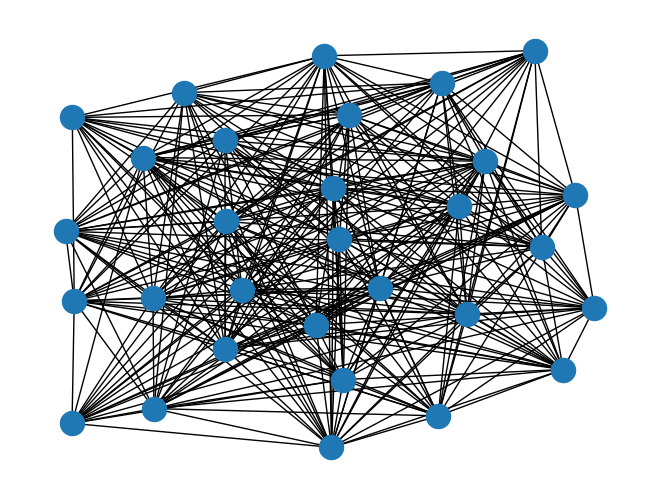

In [ ]:
nx.draw(problems[30][0]["G"])

In [54]:
method = "hpc"
ps = [100,200]
delta_gammas ={25:[0.3, 0.4, 0.5, 0.6],
              30:[0.3, 0.4, 0.5, 0.6],
              35:[0.025, 0.05, 0.1, 0.15]}
delta_betas = {25:[0.3, 0.4, 0.5, 0.6],
              30:[0.3, 0.4, 0.5, 0.6],
              35:[0.025, 0.05, 0.1, 0.15]}
nqs = [35]
cases = [99]
shots = 1000
results = np.load("./Data/WMaxcut/results.npy", allow_pickle=True).item()
for nq in nqs:
    print(f"---------   nq = {nq}   --------")
    # results[nq] = {}
    for kk in cases:
        print(f"---------   case = {kk}   --------")
        results[nq][kk] = {}
        opt_energy = round(problems[nq][kk]["opt_energy"],3)
        hamiltonian = problems[nq][kk]["ising"]
        G = problems[nq][kk]["G"]
        results[nq][kk]["energies"] = {}
        results[nq][kk]["landscape"]={}
        results[nq][kk]["best"] = {}
        for p in ps:
            best_probability = 0
            print(f"---------   p = {p}   --------")
            results[nq][kk]["energies"][p] = {}
            results[nq][kk]["landscape"][p] = {"energy":np.zeros((len(delta_betas[nq]), len(delta_gammas[nq]))), "probability":np.zeros((len(delta_betas[nq]), len(delta_gammas[nq])))}
            nn = 0
            for i, delta_beta in enumerate(delta_betas[nq]):
                for j, delta_gamma in enumerate(delta_gammas[nq]):
                    if method == "local":
                        gammas = np.arange(1, p+1) * delta_gamma/p
                        betas = np.arange(1, p+1)[::-1] * delta_beta/p
                        qc = qaoa_circ(hamiltonian, gammas, betas, nq)
                        qc = transpile(qc, backend=backend)
                        samples = backend.run(qc, shots=shots).result().get_counts()
                    elif method == "hpc":
                        with open(f"./Data/WMaxCut/samples_hpc/{nq}/{kk}/{p}/{nn}.out", "r") as file:
                            lines = file.readlines()
                        samples = defaultdict(int)
                        for line in lines[2:]:
                            columns = line.split()
                            samples[columns[0][1:-1][::-1]] += int(columns[-1])
                        shots = 10000
                        nn += 1
                    energies = defaultdict(int)
                    mean_energy = 0
                    for sample, c in samples.items():
                        e = round(energy(sample, hamiltonian), 3)
                        energies[e] += c
                        mean_energy += e*c
                    mean_energy /= shots 
                    probability = energies[opt_energy]/shots if opt_energy in energies else 0
                    results[nq][kk]["energies"][p][(delta_beta, delta_gamma)] = energies
                    results[nq][kk]["landscape"][p]["energy"][i,j] = mean_energy
                    results[nq][kk]["landscape"][p]["probability"][i,j] = probability
                    if probability > best_probability:
                        best_probability = probability
                        results[nq][kk]["best"][p] = {"probabiliy":probability, "delta_beta":delta_beta, "delta_gamma":delta_gamma, "energy":mean_energy}
                    print(f"beta:{delta_beta} | gamma: {delta_gamma}, probability: {probability}, mean energy: {mean_energy}")
# np.save("./Data/WMaxcut/results.npy", results)

---------   nq = 35   --------
---------   case = 99   --------
---------   p = 100   --------
beta:0.025 | gamma: 0.025, probability: 0.0003, mean energy: -34.32172569999989
beta:0.025 | gamma: 0.05, probability: 0.0002, mean energy: -33.56025600000009
beta:0.025 | gamma: 0.1, probability: 0, mean energy: -29.332926299999787
beta:0.025 | gamma: 0.15, probability: 0, mean energy: -26.37531929999991
beta:0.05 | gamma: 0.025, probability: 0.0011, mean energy: -38.26706630000003
beta:0.05 | gamma: 0.05, probability: 0.0061, mean energy: -43.03455539999996
beta:0.05 | gamma: 0.1, probability: 0.006, mean energy: -42.42132789999992
beta:0.05 | gamma: 0.15, probability: 0.003, mean energy: -40.337856000000095
beta:0.1 | gamma: 0.025, probability: 0.0005, mean energy: -36.882805100000034
beta:0.1 | gamma: 0.05, probability: 0.0126, mean energy: -45.342138299999974
beta:0.1 | gamma: 0.1, probability: 0.0428, mean energy: -47.46877530000004
beta:0.1 | gamma: 0.15, probability: 0.0479, mean ener

In [479]:
ps = [10,25,50,100,200]
method = "hpc"
# ps = [25]
nqs = [35]
max_nq = 20
cases = range(81,91)
shots = 1000
problems = np.load("./Data/WMaxcut/problems.npy", allow_pickle=True).item()
results = np.load("./Data/WMaxcut/results.npy", allow_pickle=True).item()
for nq in nqs:
    print(f"---------   nq = {nq}   --------")
    for kk in cases:
        print(f"---------   case = {kk}   --------")
        results[nq][kk] = {}
        opt_energy = round(problems[nq][kk]["opt_energy"],3)
        hamiltonian = problems[nq][kk]["ising"]
        G = problems[nq][kk]["G"]
        results[nq][kk]["best"] = {}
        for p in ps:
            if method == "local":
                if nq > 5 and nq < max_nq: 
                    delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq-1, nq, nq+1]])
                    delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq-1, nq, nq+1]])
                    # delta_gamma = results[nq][0]["best"][p]["delta_gamma"]
                    # delta_beta = results[nq][0]["best"][p]["delta_beta"]
                elif nq == 5:    
                    delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq, nq+1]])
                    delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq, nq+1]])
                elif nq == max_nq:    
                    delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq-1, nq]])
                    delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq-1, nq]])
                else:
                    print("here")
                gammas = np.arange(1, p+1) * delta_gamma/p
                betas = np.arange(1, p+1)[::-1] * delta_beta/p
                qc = qaoa_circ(hamiltonian, gammas, betas, nq)
                qc = transpile(qc, backend=backend)
                samples = backend.run(qc, shots=shots).result().get_counts()
            elif method == "hpc":
                delta_gamma = results[nq][0]["best"][p]["delta_gamma"]
                delta_beta = results[nq][0]["best"][p]["delta_beta"]
                with open(f"./Data/WMaxCut/samples_hpc/{nq}/{kk}/{p}/0.out", "r") as file:
                    lines = file.readlines()
                samples = defaultdict(int)
                for line in lines[2:]:
                    columns = line.split()
                    samples[columns[0][1:-1][::-1]] += int(columns[-1])
                shots = 10_000
            energies = defaultdict(int)
            mean_energy = 0
            for sample, c in samples.items():
                e = round(energy(sample, hamiltonian), 3)
                energies[e] += c
                mean_energy += e*c
            mean_energy /= shots 
            probability = energies[opt_energy]/shots if opt_energy in energies else 0
            results[nq][kk]["best"][p] = {"probabiliy":probability, "delta_beta":delta_beta, "delta_gamma":delta_gamma, "energy":mean_energy}
            print(f"p:{p} | beta:{delta_beta} | gamma: {delta_gamma}, probability: {probability}, mean energy: {mean_energy}, min_energy: {min(energies.keys())}")
np.save("./Data/WMaxcut/results.npy", results)

---------   nq = 35   --------
---------   case = 81   --------
p:10 | beta:0.5 | gamma: 0.45, probability: 0.0068, mean energy: -41.347331499999946, min_energy: -52.73
p:25 | beta:0.6 | gamma: 0.35, probability: 0.0105, mean energy: -48.28130700000007, min_energy: -52.73
p:50 | beta:0.6 | gamma: 0.35, probability: 0.074, mean energy: -50.46768460000008, min_energy: -52.73
p:100 | beta:0.5 | gamma: 0.35, probability: 0.3255, mean energy: -51.31223529999996, min_energy: -52.73
p:200 | beta:0.4 | gamma: 0.35, probability: 0.5357, mean energy: -52.46783270000002, min_energy: -52.73
---------   case = 82   --------
p:10 | beta:0.5 | gamma: 0.45, probability: 0.0043, mean energy: -40.02747180000012, min_energy: -50.984
p:25 | beta:0.6 | gamma: 0.35, probability: 0.0247, mean energy: -46.44087000000001, min_energy: -50.984
p:50 | beta:0.6 | gamma: 0.35, probability: 0.0861, mean energy: -47.801179000000005, min_energy: -50.984
p:100 | beta:0.5 | gamma: 0.35, probability: 0.0954, mean energy:

# Saving hard instances of Weighted MaxCut

In [14]:
problems_FC = np.load(f"./Data/WMaxCut_cte_no_mdl.npy", allow_pickle=True).item()
hard_instances = np.load("./Data/hard_FC_WMC.npy", allow_pickle=True).item()
nqs = [20,25,30,35,40]
hard_problems = {}
for nq in nqs:
    hard_problems[nq] = {}
    for kk, i in enumerate(hard_instances[nq]):
        H = problems_FC[nq][i]["ising_hamiltonian"]
        max_weight = max(np.abs(H.weights))
        hamiltonian = {tuple(edges):v/max_weight for edges,v in zip(H.terms, H.weights) if v > 1e-6}
        hard_problems[nq][kk] = {"ising":hamiltonian, "sol":problems_FC[nq][i]["sol"]}
np.save("./Data/WMaxCut/problems_FC_hard.npy", hard_problems)

In [6]:
method = "hpc"
delta_gammas ={20:[0.4, 0.5, 0.6, 0.7],
               25:[0.4, 0.45, 0.5],
              30:[0.3, 0.4, 0.5, 0.6],
              35:[0.35, 0.4, 0.45, 0.5],
              40:[0.35,0.4,0.45]}
delta_betas = {20:[0.4, 0.5, 0.6, 0.7],
              25:[0.4, 0.45, 0.5, 0.6],
              30:[0.3, 0.4, 0.5, 0.6],
              35:[0.3, 0.35, 0.4, 0.5],
              40:[0.35,0.4,0.45]}
nqs = [40]
cases = [0]
ps = [50, 100]
shots = 10000
problems = np.load("./Data/WMaxCut/problems_FC_hard.npy", allow_pickle=True).item()
results = np.load("./Data/WMaxcut/results_FC_hard.npy", allow_pickle=True).item()
# results = {}
for nq in nqs:
    print(f"---------   nq = {nq}   --------")
    # results[nq] = {}
    for kk in cases:
        print(f"---------   case = {kk}   --------")
        # results[nq][kk] = {}
        sol = problems[nq][kk]["sol"]
        hamiltonian = problems[nq][kk]["ising"]
        opt_energy = round(energy(sol, hamiltonian), 5)
        # results[nq][kk]["opt_energy"] = opt_energy
        # results[nq][kk]["energies"] = {}
        # results[nq][kk]["landscape"]={}
        # results[nq][kk]["best"] = {}
        for p in ps:
            best_probability = 0
            print(f"---------   p = {p}   --------")
            results[nq][kk]["energies"][p] = {}
            results[nq][kk]["landscape"][p] = {"energy":np.zeros((len(delta_betas[nq]), len(delta_gammas[nq]))), "probability":np.zeros((len(delta_betas[nq]), len(delta_gammas[nq])))}
            nn = 0
            for i, delta_beta in enumerate(delta_betas[nq]):
                for j, delta_gamma in enumerate(delta_gammas[nq]):
                    if method == "local":
                        gammas = np.arange(1, p+1) * delta_gamma/p
                        betas = np.arange(1, p+1)[::-1] * delta_beta/p
                        qc = qaoa_circ(hamiltonian, gammas, betas, nq)
                        qc = transpile(qc, backend=backend)
                        samples = backend.run(qc, shots=shots).result().get_counts()
                    elif method == "hpc":
                        with open(f"./Data/WMaxCut/samples_FC/{nq}/{kk}/{p}/{nn}.out", "r") as file:
                            lines = file.readlines()
                        samples = defaultdict(int)
                        for line in lines[2:]:
                            columns = line.split()
                            samples[columns[0][1:-1][::-1]] += int(columns[-1])

                        shots = 10000
                        nn += 1
                    energies = defaultdict(int)
                    mean_energy = 0
                    # samples = mitigate(samples, hamiltonian)
                    for sample, c in samples.items():
                        e = round(energy(sample, hamiltonian), 5)
                        energies[e] += c
                        mean_energy += e*c
                    mean_energy /= shots 
                    probability = energies[opt_energy]/shots if opt_energy in energies else 0
                    results[nq][kk]["energies"][p][(delta_beta, delta_gamma)] = energies
                    results[nq][kk]["landscape"][p]["energy"][i,j] = mean_energy
                    results[nq][kk]["landscape"][p]["probability"][i,j] = probability
                    if probability > best_probability:
                        best_probability = probability
                        STS = int(np.ceil(np.log(1-0.99)/np.log(1-probability)))
                        results[nq][kk]["best"][p] = {"STS":STS,"probability":probability, "delta_beta":delta_beta, "delta_gamma":delta_gamma, "energy":mean_energy}
                    print(f"i:{nn} | beta:{delta_beta} | gamma: {delta_gamma}, probability: {probability}, mean energy: {mean_energy}")
np.save("./Data/WMaxcut/results_FC_hard.npy", results)

---------   nq = 40   --------
---------   case = 0   --------
---------   p = 50   --------
i:1 | beta:0.35 | gamma: 0.35, probability: 0.0022, mean energy: -53.82056440000015
i:2 | beta:0.35 | gamma: 0.4, probability: 0.0021, mean energy: -51.26478259999997
i:3 | beta:0.35 | gamma: 0.45, probability: 0.0023, mean energy: -46.42054340000018
i:4 | beta:0.4 | gamma: 0.35, probability: 0.0016, mean energy: -51.66311060000012
i:5 | beta:0.4 | gamma: 0.4, probability: 0.0017, mean energy: -45.6952097999998
i:6 | beta:0.4 | gamma: 0.45, probability: 0.0011, mean energy: -37.84431960000003
i:7 | beta:0.45 | gamma: 0.35, probability: 0.0011, mean energy: -44.966215399999896
i:8 | beta:0.45 | gamma: 0.4, probability: 0.0002, mean energy: -34.30223900000018
i:9 | beta:0.45 | gamma: 0.45, probability: 0.0001, mean energy: -25.32195320000005
---------   p = 100   --------
i:1 | beta:0.35 | gamma: 0.35, probability: 0.0048, mean energy: -55.95674500000004
i:2 | beta:0.35 | gamma: 0.4, probability:

In [9]:
kk = 0
nq = 40
print(f'betas = ',{p:results[nq][kk]["best"][p]["delta_beta"] for p in [50,100]})
print(f'gammas = ',{p:results[nq][kk]["best"][p]["delta_gamma"] for p in [50,100]})


betas =  {50: 0.35, 100: 0.45}
gammas =  {50: 0.45, 100: 0.35}


In [21]:
ps = [100]
method = "hpc"
nqs = [40]
max_nq = 20
cases = [i for i in range(1,20)]
shots = 1000
problems = np.load("./Data/WMaxCut/problems_FC_hard.npy", allow_pickle=True).item()
results = np.load("./Data/WMaxcut/results_FC_hard.npy", allow_pickle=True).item()
for nq in nqs:
    print(f"---------   nq = {nq}   --------")
    for kk in cases:
        print(f"---------   case = {kk}   --------")
        # results[nq][kk] = {}
        hamiltonian = problems[nq][kk]["ising"]
        sol = problems[nq][kk]["sol"]
        opt_energy = round(energy(sol, hamiltonian), 5)
        results[nq][kk]["opt_energy"] = opt_energy
        # results[nq][kk]["best"] = {}
        for p in ps:
            if method == "local":
                # delta_gamma = results[nq][0]["best"][p]["delta_gamma"]
                # delta_beta = results[nq][0]["best"][p]["delta_beta"]
                delta_gamma = 0.4
                delta_beta = 0.4
                gammas = np.arange(1, p+1) * delta_gamma/p
                betas = np.arange(1, p+1)[::-1] * delta_beta/p
                qc = qaoa_circ(hamiltonian, gammas, betas, nq)
                qc = transpile(qc, backend=backend)
                samples = backend.run(qc, shots=shots).result().get_counts()
            elif method == "hpc":
                delta_gamma = results[nq][0]["best"][p]["delta_gamma"]
                delta_beta = results[nq][0]["best"][p]["delta_beta"]
                with open(f"./Data/WMaxCut/samples_FC/{nq}/{kk}/{p}/0.out", "r") as file:
                    lines = file.readlines()
                samples = defaultdict(int)
                for line in lines[2:]:
                    columns = line.split()
                    samples[columns[0][1:-1][::-1]] += int(columns[-1])
                shots = 10_000
            energies = defaultdict(int)
            mean_energy = 0
            for sample, c in samples.items():
                e = round(energy(sample, hamiltonian), 5)
                energies[e] += c
                mean_energy += e*c
            mean_energy /= shots 
            probability = energies[opt_energy]/shots if opt_energy in energies else 0
            STS = int(np.ceil(np.log(1-0.99)/np.log(1-probability)))
            results[nq][kk]["best"][p] = {"STS":STS, "probability":probability, "delta_beta":delta_beta, "delta_gamma":delta_gamma, "energy":mean_energy}
            print(f"p:{p} | beta:{delta_beta} | gamma: {delta_gamma}, probability: {probability}, mean energy: {mean_energy}, min_energy: {min(energies.keys())}")
np.save("./Data/WMaxcut/results_FC_hard.npy", results)

---------   nq = 40   --------
---------   case = 1   --------
p:100 | beta:0.45 | gamma: 0.35, probability: 0.3041, mean energy: -53.079718001999936, min_energy: -57.34604
---------   case = 2   --------
p:100 | beta:0.45 | gamma: 0.35, probability: 0.0866, mean energy: -52.390364976000015, min_energy: -56.14715
---------   case = 3   --------
p:100 | beta:0.45 | gamma: 0.35, probability: 0.3945, mean energy: -54.38068254099995, min_energy: -57.7047
---------   case = 4   --------
p:100 | beta:0.45 | gamma: 0.35, probability: 0.0673, mean energy: -52.10694720000004, min_energy: -55.774
---------   case = 5   --------
p:100 | beta:0.45 | gamma: 0.35, probability: 0.1652, mean energy: -57.62238689999998, min_energy: -61.469
---------   case = 6   --------
p:100 | beta:0.45 | gamma: 0.35, probability: 0.3234, mean energy: -52.44907582100004, min_energy: -55.61161
---------   case = 7   --------
p:100 | beta:0.45 | gamma: 0.35, probability: 0.1128, mean energy: -53.993273799999976, min_en

In [13]:
results_lrqaoa_old = np.load("/Users/alejomonbar/Documents/GitHub/TheMagicSchedule/Data/WMaxCut_res_TTS_new.npy", allow_pickle=True).item()


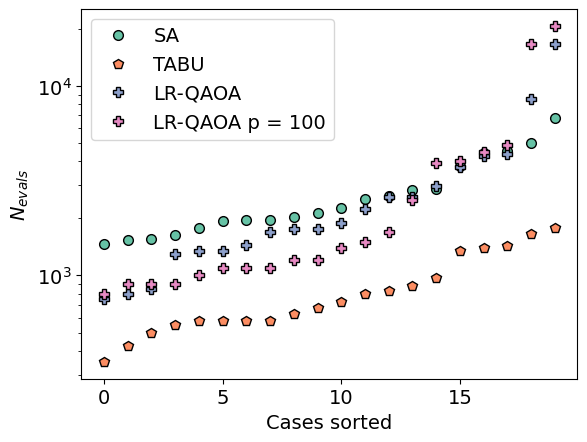

In [310]:
colors= plt.get_cmap("Set2")
results_tabu = np.load(f"./Data/WMC_TABU_results.npy", allow_pickle=True).item()
results_sa = np.load(f"./Data/WMC_SA_results.npy", allow_pickle=True).item()
arg_sort_dict = np.load("./Data/hard_FC_WMC.npy", allow_pickle=True).item()

hard_problems = {}
fig, ax = plt.subplots()
nq = 35
sweeps = 10
y1 = np.array([sweeps*results_sa[nq][kk]["SA"][sweeps]["STS"] for kk in results_sa[nq].keys()])
iters = 25
y2 = np.array([iters*results_tabu[nq][kk]["TABU"][iters]["STS"] for kk in results_sa[nq].keys()])
arg_sort = arg_sort_dict[nq]
ax.plot(range(len(arg_sort)), sorted(y1[arg_sort]), marker="o", linewidth=0, markeredgecolor="black", color=colors(0), markersize=7, label="SA")

ax.plot(range(len(arg_sort)), sorted(y2[arg_sort]), marker="p", linewidth=0, markeredgecolor="black", color=colors(1), label="TABU", markersize=7)
p = 50

yp50 = np.array([p * int(np.ceil(np.log(1-0.99)/np.log(1-results[nq][kk]["best"][p]["probability"]))) for kk in range(20)])
y_sort = np.argsort(yp50)
ax.plot(range(len(arg_sort)), yp50[y_sort], marker="P", linewidth=0, markeredgecolor="black", color=colors(2), label=f"LR-QAOA", markersize=7)
p = 100
yp100 = np.array([p * int(np.ceil(np.log(1-0.99)/np.log(1-results[nq][kk]["best"][p]["probability"]))) for kk in range(20)])
ax.plot(range(len(arg_sort)), sorted(yp100), marker="P", linewidth=0, markeredgecolor="black", color=colors(3), label=f"LR-QAOA p = 100", markersize=7)
ax.set_ylabel(r"$N_{evals}$")
ax.set_xlabel("Cases sorted")

ax.set_yscale("log")
ax.legend()

# Figures

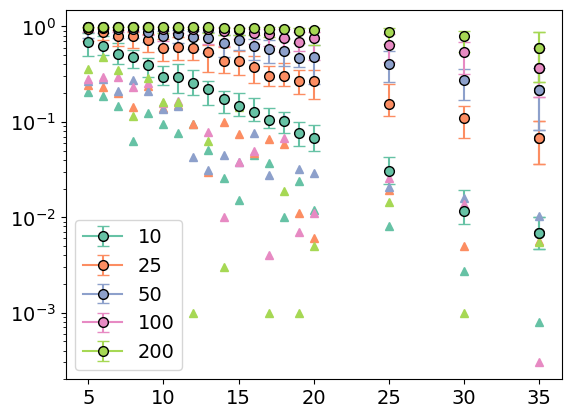

In [480]:
fig, ax  = plt.subplots()
# results = np.load("./Data/WMaxcut/results.npy", allow_pickle=True).item()

sort = defaultdict(dict)
colors =  plt.get_cmap("Set2")
for i, p in enumerate([10,25,50,100,200]):
    for nq in sorted(results.keys()):
        y = [results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]
        quartiles = np.percentile(np.array(y), [25, 50, 75])
        sort[p][nq] = quartiles[1]
        ax.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black")
    ax.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black", label=p)

    y_min = [np.min([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    std = [np.std([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    # plt.errorbar(sorted(results.keys()), y, std , marker="o", label=p, color=colors(3*i), capsize=3)
    ax.plot(sorted(results.keys()), y_min , marker="^", linewidth=0, color=colors(i))
nqs = range(5, 20)
# plt.plot(nqs, [1/2**nq for nq in nqs], linestyle="--", color="black")
ax.legend()
ax.set_yscale("log")

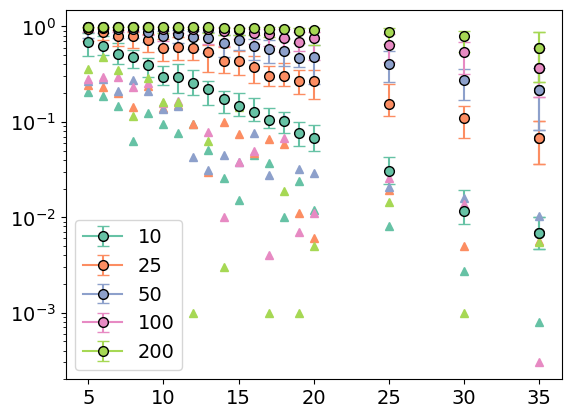

In [481]:
fig, ax  = plt.subplots()
results = np.load("./Data/WMaxcut/results.npy", allow_pickle=True).item()

sort = defaultdict(dict)
colors =  plt.get_cmap("Set2")
for i, p in enumerate([10,25,50,100,200]):
    for nq in sorted(results.keys()):
        y = [results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]
        quartiles = np.percentile(np.array(y), [25, 50, 75])
        sort[p][nq] = quartiles[1]
        ax.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black")
    ax.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black", label=p)

    y_min = [np.min([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    std = [np.std([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    # plt.errorbar(sorted(results.keys()), y, std , marker="o", label=p, color=colors(3*i), capsize=3)
    ax.plot(sorted(results.keys()), y_min , marker="^", linewidth=0, color=colors(i))
nqs = range(5, 20)
# plt.plot(nqs, [1/2**nq for nq in nqs], linestyle="--", color="black")
ax.legend()
ax.set_yscale("log")

Text(0.5, 0, '$p$')

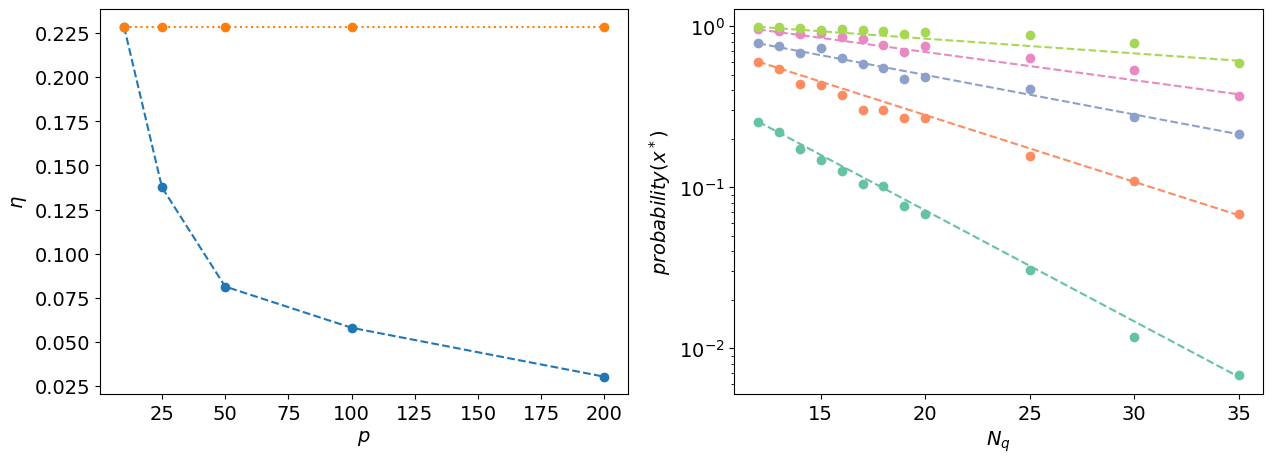

In [482]:
def func(x, p, nqs, y_real):
    """C:constant, eta:important value of the scale"""
    eta = x[0]
    C = x[1]
    y_eff = np.array([-eta*(nq - nqs[0]) for nq in nqs])
    return ((y_eff[:-1] - y_real[:-1])**2).mean() +  (y_eff[-1] - y_real[-1])**2


colors = plt.get_cmap("Set2")
ps = [10,25,50,100,200]
etas = {}
Cs = {}
error = {}
fig, ax = plt.subplots(1,2, figsize=(15,5))
for p in ps:
    nqs = list(range(12,21)) + [25,30,35] 
    y_real = [np.log2(sort[p][nq]/sort[p][nqs[0]]) for nq in nqs]
    x0 = [0.5 , 0.1]
    sol = minimize(func, x0, args=(p, nqs, y_real))
    etas[p] = sol.x[0]
    Cs[p] = sol.x[1]
    error[p] = sol.fun

ax[0].plot(sorted(ps), [etas[p] for p in sorted(ps)], marker="o", linestyle="--")
ax[0].plot(sorted(ps), [etas[ps[0]] for p in sorted(ps)], marker="o", linestyle=":")

for i, p in enumerate(sort.keys()):
    ax[1].plot(nqs, [np.mean(sort[p][nq]) for nq in nqs], marker="o", linewidth=0, color=colors(i))
    ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[p]*(nq - nqs[0])) for nq in nqs], linestyle="--", color=colors(i))
    # ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[ps[0]]*(nq - nqs[0])) for nq in nqs], linestyle=":", color=colors(i))

ax[1].set_yscale("log")
ax[1].set_ylabel(r"$probability(x^*)$")
ax[1].set_xlabel(r"$N_q$")
ax[0].set_ylabel(r"$\eta$")
ax[0].set_xlabel(r"$p$")
# ax[0].set_yscale("log")
# ax[0].set_ylim(0,10)

Text(0.5, 0, '$p$')

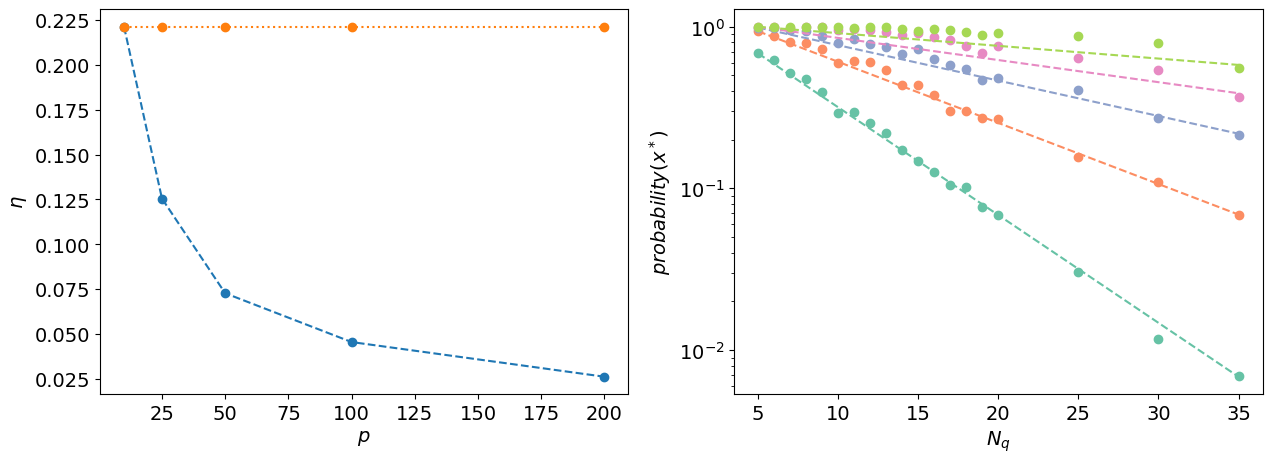

In [9]:
def func(x, p, nqs, y_real):
    """C:constant, eta:important value of the scale"""
    eta = x[0]
    C = x[1]
    y_eff = np.array([-eta*(nq - nqs[0]) for nq in nqs])
    return ((y_eff[:-1] - y_real[:-1])**2).mean() +  (y_eff[-1] - y_real[-1])**2


colors = plt.get_cmap("Set2")
ps = [10,25,50,100,200]
etas = {}
Cs = {}
error = {}
fig, ax = plt.subplots(1,2, figsize=(15,5))
for p in ps:
    nqs = list(range(5,21)) + [25,30,35] 
    y_real = [np.log2(sort[p][nq]/sort[p][nqs[0]]) for nq in nqs]
    x0 = [0.5 , 0.1]
    sol = minimize(func, x0, args=(p, nqs, y_real))
    etas[p] = sol.x[0]
    Cs[p] = sol.x[1]
    error[p] = sol.fun

ax[0].plot(sorted(ps), [etas[p] for p in sorted(ps)], marker="o", linestyle="--")
ax[0].plot(sorted(ps), [etas[ps[0]] for p in sorted(ps)], marker="o", linestyle=":")

for i, p in enumerate(sort.keys()):
    ax[1].plot(nqs, [np.mean(sort[p][nq]) for nq in nqs], marker="o", linewidth=0, color=colors(i))
    ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[p]*(nq - nqs[0])) for nq in nqs], linestyle="--", color=colors(i))
    # ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[ps[0]]*(nq - nqs[0])) for nq in nqs], linestyle=":", color=colors(i))

ax[1].set_yscale("log")
ax[1].set_ylabel(r"$probability(x^*)$")
ax[1].set_xlabel(r"$N_q$")
ax[0].set_ylabel(r"$\eta$")
ax[0].set_xlabel(r"$p$")
# ax[0].set_ylim(0,10)

Text(0, 0.5, '$\\gamma$')

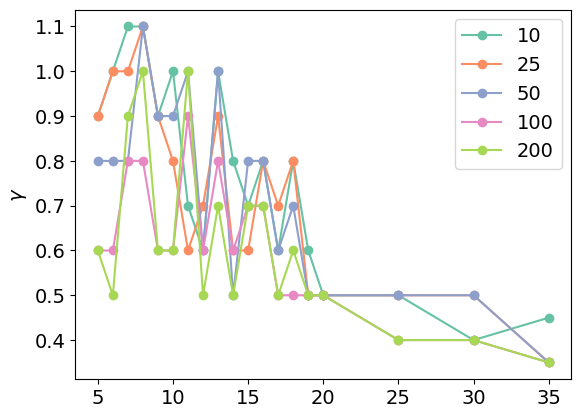

In [11]:
kk = 0
for i, p in enumerate(ps):
    plt.plot(sorted(results.keys()), [results[nq][kk]["best"][p]["delta_gamma"] for nq in sorted(results.keys())], marker="o", label=p, color=colors(i))
plt.legend()
plt.ylabel(r"$\gamma$")

Text(0, 0.5, '$\\gamma$')

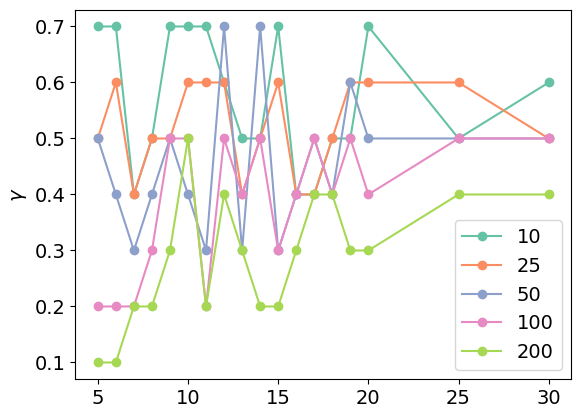

In [37]:
kk = 0
for i, p in enumerate(ps):
    plt.plot(sorted(results.keys()), [results[nq][kk]["best"][p]["delta_beta"] for nq in sorted(results.keys())], marker="o", label=p, color=colors(i))
plt.legend()
plt.ylabel(r"$\gamma$")

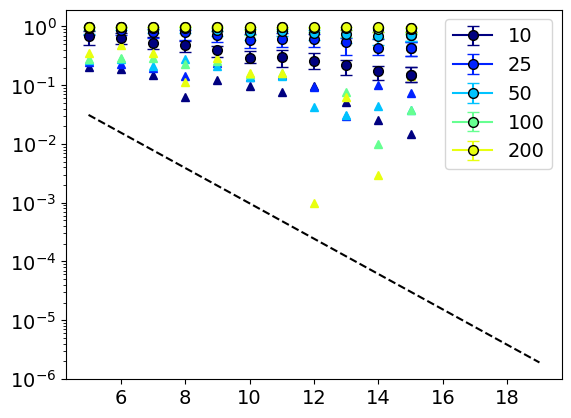

In [23]:
for i, p in enumerate([10,25,50,100,200]):
    for nq in sorted(results.keys()):
        y = [results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]
        quartiles = np.percentile(np.array(y), [25, 50, 75])
        plt.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(3*i), capsize=4, markersize=7, markeredgecolor="black")
    plt.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(3*i), capsize=4, markersize=7, markeredgecolor="black", label=p)

    y_min = [np.min([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    std = [np.std([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    # plt.errorbar(sorted(results.keys()), y, std , marker="o", label=p, color=colors(3*i), capsize=3)
    plt.plot(sorted(results.keys()), y_min , marker="^", linewidth=0, color=colors(3*i))
nqs = range(5, 20)
plt.plot(nqs, [1/2**nq for nq in nqs], linestyle="--", color="black")
plt.legend()
plt.yscale("log")

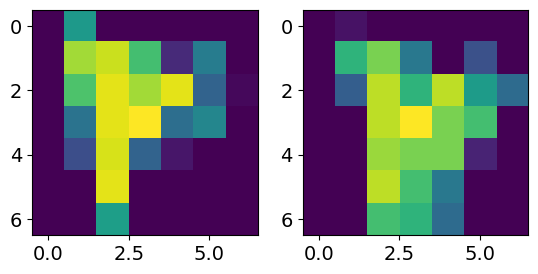

In [154]:
p = 100
nq = 18
fig, ax = plt.subplots(1,2)
ax[0].imshow(-results[nq][kk]["landscape"][p]["energy"], vmin=6, vmax=np.max(-results[nq][kk]["landscape"][p]["energy"]))
ax[1].imshow(results[nq][kk]["landscape"][p]["probability"], vmin= 0.8, vmax=np.max(results[nq][kk]["landscape"][p]["probability"]))

In [ ]:
nq = 56
G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from([(i,j) for i in range(nq) for j in range(i+1, nq)])
pos = nx.circular_layout(G)
fig, ax = plt.subplots(figsize=(10,10))
nx.draw(G, pos=pos, ax=ax, edgecolors='black', width=0.2)
fig.savefig(f"./Figures/FC_{nq}.pdf", transparent=True, bbox_inches="tight")

# Repeating Graph

In [149]:
def qaoa_maxcut(G, gammas, betas):
    # Get the number of nodes in the graph
    nodes = len(G.nodes())
    
    # Extract edges as tuples (i, j)
    edges = [(i, j) for i, j in G.edges()]
    
    # Find the maximum absolute edge weight for normalization
    max_w = np.max(np.abs([G[i][j]["weight"] for i, j in G.edges()]))
    
    # Number of QAOA layers (depth of the ansatz)
    layers = len(gammas)
    
    # Create a quantum circuit with 'nodes' qubits
    qc = QuantumCircuit(nodes)
    
    # Apply Hadamard gates to all qubits to create a superposition
    qc.h(range(nodes))
    
    # Iterate through QAOA layers
    for p in range(layers):
        # Generate a permutation to optimize circuit depth
        permutations = np.arange(nodes)
        
        # Apply the ZZ-interaction gates based on the graph edges
        for jj in range(nodes):
            for k in range(jj % 2, nodes - 1, 2):
                qubit_pair = (permutations[k], permutations[k+1])
                
                # Check if the qubit pair corresponds to an edge in the graph
                if qubit_pair in edges or reversed(qubit_pair) in edges:
                    # Apply an RZZ (ZZ-rotation) gate weighted by the graph edge weight
                    qc.rzz(2 * gammas[p] * G[qubit_pair[0]][qubit_pair[1]]["weight"] / max_w, *qubit_pair)
                
                # Swap the qubits to optimize execution
                permutations[[k, k+1]] = permutations[[k+1, k]]
        
        # Apply RX rotations to all qubits (single-qubit mixing gates)
        qc.rx(-2 * betas[p], range(nodes))
    
    # Return the constructed quantum circuit
    return qc

def hamming_distance(x1, x2):
    """
    Computes the Hamming distance between two bitstrings.
    
    Parameters:
    x1 (str): First bitstring.
    x2 (str): Second bitstring.
    
    Returns:
    int: Hamming distance between the two bitstrings.
    """
    distance = 0
    for i, s in enumerate(x1):
        if s != x2[i]:
            distance += 1
    return distance

In [ ]:
nq = 8
kk = 0
lambd = -1
G_1 = problems[nq][kk]["G"]
G = nx.Graph()
G.add_nodes_from(range(2*nq))
for i, j in G_1.edges():
    G.add_weighted_edges_from([[i,j,G_1[i][j]["weight"]]])
    G.add_weighted_edges_from([[i+nq,j+nq,G_1[i][j]["weight"]]])
    G.add_weighted_edges_from([[i+nq,j+nq,G_1[i][j]["weight"]]])
for i in range(nq):
    G.add_weighted_edges_from([[i,i+nq,lambd]])

p = 50
delta_gamma = 0.7
delta_beta = 0.6

gammas = np.arange(1, p+1) * delta_gamma/p
betas = np.arange(1, p+1)[::-1] * delta_beta/p
hamiltonian = {}
qc = qaoa_maxcut(G, gammas, betas)
qc.measure_all()
shots = 1000
samples = backend.run(qc, shots=shots).result().get_counts()
samples_split = defaultdict(int)
sol1 = problems[nq][kk]["sol"]
sol2 = "".join(("1" if i == "0" else "0") for i in sol1)
for k,v in samples.items():
    # print(k[:nq][::-1], k[nq:][::-1],v, min(hamming_distance(sol1,k[:nq][::-1]),hamming_distance(sol2,k[nq:][::-1])), min(hamming_distance(sol1,k[:nq][::-1]),hamming_distance(sol2,k[nq:][::-1])))
    print(k[:nq][::-1], k[nq:2*nq][::-1],v)
    samples_split[k[:nq][::-1]] += v
    samples_split[k[nq:][::-1]] += v

print((samples_split[sol1] + samples_split[sol2])/(2*shots))

In [ ]:
delta_gamma = 1
delta_beta = 0.3

gammas = np.arange(1, p+1) * delta_gamma/p
betas = np.arange(1, p+1)[::-1] * delta_beta/p

gammas = np.arange(1, p+1) * delta_gamma/p
betas = np.arange(1, p+1)[::-1] * delta_beta/p
hamiltonian = {}
qc = qaoa_maxcut(G_1, gammas, betas)
qc.measure_all()
samples = backend.run(qc, shots=shots).result().get_counts()
for k,v in samples.items():
    print(k[:nq][::-1], k[nq:][::-1],v,min(hamming_distance(sol1,k[:nq][::-1]),hamming_distance(sol2,k[:nq][::-1])))
print((samples[sol1[::-1]] + samples[sol2[::-1]])/shots)


# Regular graphs 

In [174]:
def qaoa_maxcut(gammas, betas, G):
    total_qubits = G.number_of_nodes()
    p = len(gammas) 
    nodes = G.nodes()
    weights = [G[i][j]["weight"] for i,j in G.edges()]
    max_weight = max(np.abs(weights))
    qc = QuantumCircuit(total_qubits, len(nodes))
    qc.h(nodes)
    for pi in range(p):
        for i, j in G.edges():
            qc.rzz(2 * gammas[pi] * G[i][j]["weight"]/max_weight, i, j)
        qc.rx(-2*betas[pi], nodes)
    return qc

def cost_maxcut(bitstring, weights):
    cost = 0
    for i, j in weights.keys():
        if bitstring[i] + bitstring[j] in ["10","01"]:
            cost += weights[i,j]
    return cost

def objective_MaxCut(samples_dict, G, optimal):
    weights = {(i,j):(G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    max_cost = cost_maxcut(optimal, weights)
    results = []
    probability = 0 
    for bitstring, counts in samples_dict.items():
        cost = cost_maxcut(bitstring, weights)
        r  = cost/max_cost
        results.append([cost, r, counts])
        if abs(cost - max_cost) < 1e-6:
            probability += counts
    results = np.array(results)
    shots = np.sum(results[:,2])
    probability /= shots
    rT = np.sum(results[:,0] * results[:,2])/(shots*max_cost)
    return {"results":np.array(results), "G":G, "weights":weights, "max_cut":max_cost, "r":rT, "probability":probability}

def MaxCut(G):
    """
    Input:
        G: Networkx graph
    Output:
        mdl: Docplex model
    """
    # MIS model as a QUBO problem
    mdl = Model('MaxCut')
    x = {i: mdl.binary_var(name=f"x_{i}") for i in sorted(G.nodes)}
    cost = 0
    for i, j in G.edges:
        if nx.is_weighted(G):
            cost += - G[i][j]["weight"] * (x[i] * (1 - x[j]) + x[j] * (1 - x[i]))
        else:
            cost += - (x[i] * (1 - x[j]) + x[j] * (1 - x[i]))
    mdl.minimize(cost)
    return mdl


In [228]:
results = {}

In [232]:
n_r = 4
nq = 10
graph_name = f"regular_graph_{n_r}-Nq_{nq}"
results[graph_name] = {}

G = nx.random_regular_graph(n_r, nq)
for i, j in G.edges():
    G[i][j]["weight"] = np.random.choice([0.05,0.1,0.25,1])

mdl = MaxCut(G)
mdl.solve()
results[graph_name]["G"] = G
results[graph_name]["optimal"] = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())


In [233]:
graph_name = "iqm_garnet"
results[graph_name] = {}
problems = np.load("/Users/alejomonbar/Documents/GitHub/LR-QAOA-QPU-Benchmarking/Data/NL-problems.npy", allow_pickle=True).item()
results[graph_name]["G"] = problems["iqm_garnet"]["G"]
results[graph_name]["optimal"] = problems["iqm_garnet"]["sol"][0]

In [251]:
g = problems["iqm_garnet"]["G"]
set([g[i][j]["weight"] for i,j in g.edges()])

{np.float64(0.05), np.float64(0.1), np.float64(0.25), np.float64(1.0)}

In [234]:
graph_name = "HE-Nq=20"
nq = 20
results[graph_name] = {}
problems = np.load("/Users/alejomonbar/Documents/GitHub/LR-QAOA-QPU-Benchmarking/Data/NL-problems.npy", allow_pickle=True).item()
G_fez = problems["Heron-r2"]["G"]
G = nx.Graph()
G.add_nodes_from(range(nq))
for i,j in G_fez.edges():
    if i < nq and j < nq:
        w = np.random.choice([0.05,0.1,0.25,1])
        G.add_weighted_edges_from([[i,j,w]])
mdl = MaxCut(G)
mdl.solve()
results[graph_name]["G"] = G
results[graph_name]["optimal"] = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())

In [247]:
graph_name = "iqm_garnet"
# graph_name = "HE-Nq=20"
n_r = 3
nq = 20
graph_name = f"regular_graph_{n_r}-Nq_{nq}"
delta_beta = delta_beta = 0.75
G = results[graph_name]["G"]
nq = G.number_of_nodes()
ps = [0,3,4,5,6,7,8,9,10,15,20,30,40,50]
results[graph_name]["ps"] = ps
shots = 10_000
for p in ps:
    print(f" ------- {p} ---------")
    gammas = np.arange(1, p+1) * delta_gamma/p
    betas = np.arange(1, p+1)[::-1] * delta_beta/p
    qc = qaoa_maxcut(gammas, betas, G)
    qc.measure(sorted(G.nodes()), reversed(range(nq)))
    samples = backend.run(qc, shots=shots).result().get_counts() 
    results[graph_name][p] = objective_MaxCut(samples, G, results[graph_name]["optimal"])
    


 ------- 0 ---------
 ------- 3 ---------
 ------- 4 ---------
 ------- 5 ---------
 ------- 6 ---------
 ------- 7 ---------
 ------- 8 ---------
 ------- 9 ---------
 ------- 10 ---------
 ------- 15 ---------
 ------- 20 ---------
 ------- 30 ---------
 ------- 40 ---------
 ------- 50 ---------


In [258]:
np.save("./Data/QPUs_comparison.npy", results)

regular_graph_3-Nq_10
regular_graph_3-Nq_20
regular_graph_4-Nq_20
regular_graph_4-Nq_10
iqm_garnet


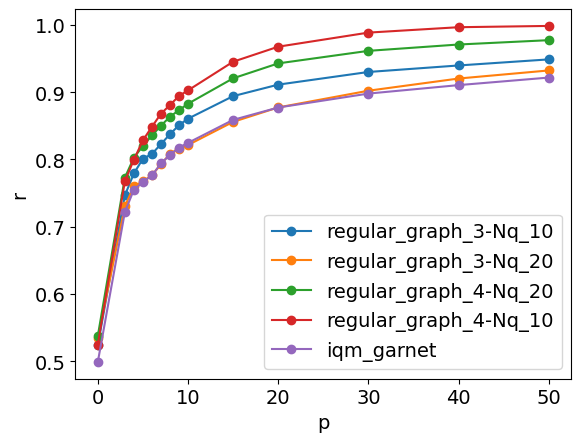

In [259]:
results = np.load("./Data/QPUs_comparison.npy", allow_pickle=True).item()
fig, ax = plt.subplots()
for graph_name in results.keys():
    print(graph_name)
    ax.plot(results[graph_name]["ps"], [results[graph_name][p]["r"] for p in results[graph_name]["ps"]], marker="o", label=graph_name)

ax.set_ylabel("r")
ax.set_xlabel("p")
ax.legend()